In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop.generator import *
from seqprop.predictor import *
from seqprop.optimizer import *

from definitions.optimus5_retrained_genetic_algo import load_saved_predictor

import warnings
warnings.simplefilter("ignore")

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [3]:

## Download Optimus 5' UTR model 
#!wget https://github.com/pjsample/human_5utr_modeling/raw/master/modeling/saved_models/main_MRL_model.hdf5
#!wget https://github.com/pjsample/human_5utr_modeling/raw/master/modeling/saved_models/retrained_evolution_model.hdf5
#!wget https://github.com/pjsample/human_5utr_modeling/raw/master/modeling/saved_models/evolution_model.hdf5


In [4]:

def get_punish_atg(pwm_start, pwm_end) :
    
    def punish(pwm) :

        atg_score = K.sum(pwm[..., pwm_start:pwm_end-2, 0, 0] * pwm[..., pwm_start+1:pwm_end-1, 3, 0] * pwm[..., pwm_start+1:pwm_end-1, 2, 0], axis=-1)
        
        return atg_score
    
    return punish

#Define target isoform loss function
def get_earthmover_loss(pwm_start=0, pwm_end=70, pwm_target_bits=1.8, pwm_entropy_weight=0.0) :
    
    punish_atg = 0.0
    
    entropy_mse = get_margin_entropy(pwm_start=pwm_start, pwm_end=pwm_end, min_bits=pwm_target_bits)
    
    punish_atg_func = get_punish_atg(pwm_start=pwm_start, pwm_end=pwm_end)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, pred_score = predictor_outputs

        #Specify costs
        fitness_loss = -1.0 * K.mean(pred_score[..., 0], axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_atg * K.mean(punish_atg_func(sampled_pwm), axis=0)
        
        entropy_loss = pwm_entropy_weight * entropy_mse(pwm)
        
        #Compute total loss
        total_loss = fitness_loss + seq_loss + entropy_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, pred_score = predictor_outputs

        #Specify costs
        fitness_loss = -1.0 * K.mean(pred_score[..., 0], axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_atg * K.mean(punish_atg_func(sampled_pwm), axis=0)
        
        entropy_loss = pwm_entropy_weight * entropy_mse(pwm)
        
        #Compute total loss
        total_loss = fitness_loss + seq_loss + entropy_loss

        return K.reshape(K.mean(total_loss, axis=0), (1,))
    
    return loss_func, val_loss_func


def get_nop_transform() :
    
    def _transform_func(pwm) :
        
        return pwm
    
    return _transform_func

class ValidationCallback(Callback):
    def __init__(self, val_name, val_loss_model, val_steps) :
        self.val_name = val_name
        self.val_loss_model = val_loss_model
        self.val_steps = val_steps
        
        self.val_loss_history = []
        
        #Track val loss
        self.val_loss_history.append(self.val_loss_model.predict(x=None, steps=self.val_steps)[0])
    
    def on_batch_end(self, batch, logs={}) :
        #Track val loss
        val_loss_value = self.val_loss_model.predict(x=None, steps=self.val_steps)[0]
        self.val_loss_history.append(val_loss_value)

#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, loss_funcs, val_loss_funcs, transform_funcs, n_sequences=1, n_samples=1, n_valid_samples=1, eval_mode='sample', normalize_logits=False, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    seqprop_predictors = []
    valid_monitors = []
    train_histories = []
    valid_histories = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        val_loss_func = val_loss_funcs[obj_ix]
        transform_func = transform_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=len(sequence_template), n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=transform_func, validation_sample_mode='sample')
        #for layer in seqprop_generator.layers :
        #    if 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_generator = build_generator(seq_length=len(sequence_template), n_sequences=n_sequences, n_samples=n_valid_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=None, validation_sample_mode='sample', master_generator=seqprop_generator)
        for layer in valid_generator.layers :
            #if 'policy' not in layer.name :
            layer.name += "_valversion"
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=None), n_sequences=n_sequences, n_samples=n_samples, eval_mode=eval_mode)
        #for layer in seqprop_predictor.layers :
        #    if '_trainversion' not in layer.name and 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_predictor = build_predictor(valid_generator, load_saved_predictor(model_path, library_context=None), n_sequences=n_sequences, n_samples=n_valid_samples, eval_mode='sample')
        for layer in valid_predictor.layers :
            if '_valversion' not in layer.name :# and 'policy' not in layer.name :
                layer.name += "_valversion"
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        _, valid_loss_model = build_loss_model(valid_predictor, val_loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.5)
        #opt = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0, nesterov=True)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        def get_logit(p) :
            return np.log(p / (1. - p))
        
        #Specify callback entities
        #measure_func = lambda pred_outs: np.mean(get_logit(np.expand_dims(pred_outs[0], axis=0) if len(pred_outs[0].shape) <= 2 else pred_outs[0]), axis=0)
        measure_func = lambda pred_outs: np.mean(np.expand_dims(np.expand_dims(pred_outs[0][..., 0], axis=-1), axis=0) if len(pred_outs[0].shape) <= 2 else np.expand_dims(pred_outs[0][..., 0], axis=-1), axis=0)
        
        #train_monitor = FlexibleSeqPropMonitor(predictor=seqprop_predictor, plot_on_train_end=False, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='MRL Score', plot_pwm_start=0, plot_pwm_end=-1, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(10, 1.0))
        valid_monitor = FlexibleSeqPropMonitor(predictor=valid_predictor, plot_on_train_end=True, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='MRL Score', plot_pwm_start=0, plot_pwm_end=54, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(10, 1.0))
        
        train_history = ValidationCallback('loss', loss_model, 1)
        valid_history = ValidationCallback('val_loss', valid_loss_model, 1)
        
        callbacks =[
            #EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            valid_monitor,
            train_history,
            valid_history
        ]
        
        #Fit Loss Model
        _ = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        valid_monitor.predictor = None
        train_history.val_loss_model = None
        valid_history.val_loss_model = None
        
        seqprop_predictors.append(seqprop_predictor)
        valid_monitors.append(valid_monitor)
        train_histories.append(train_history)
        valid_histories.append(valid_history)

    return seqprop_predictors, valid_monitors, train_histories, valid_histories


In [7]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '')
model_name = 'evolution_model.hdf5'
model_path = os.path.join(save_dir, model_name)


<h2>Run SeqProp to maximize one of the Optimus 5' model outputs</h2>


In [8]:
import random

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)


Running optimization experiment 'Optimus-5 output maximization'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 17s 8ms/step - loss: -1.7172


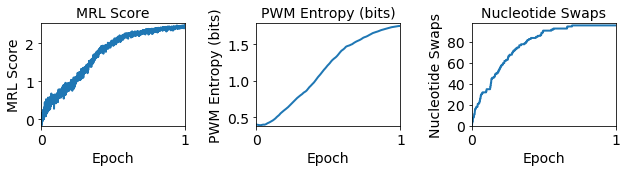

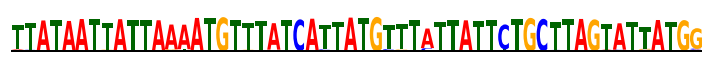

In [9]:

seq_template = 'N' * 54

rand_seed = 1177#14755

#Run SeqProp Optimization

K.clear_session()

set_seed(rand_seed)

print("Running optimization experiment 'Optimus-5 output maximization'")

#Number of PWMs to generate per objective
n_sequences = 1
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000
#Either 'pwm' or 'sample'
eval_mode = 'sample'
#Normalize sequence logits
normalize_logits = True
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 64

target_output_ixs = [
    125#137
]

sequence_templates = [
    seq_template
]

losses, val_losses = zip(*[
    get_earthmover_loss(
        pwm_start=0,
        pwm_end=54,
        pwm_target_bits=1.8,
        pwm_entropy_weight=0.0
    )
])

transforms = [
    None
]

seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(sequence_templates, losses, val_losses, transforms, n_sequences, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]


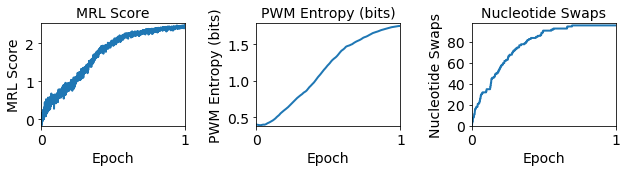

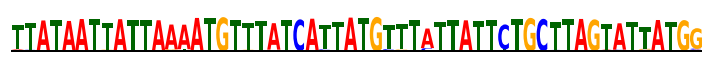

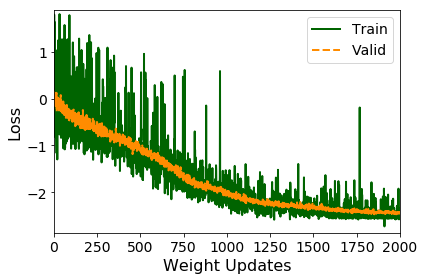

In [10]:
#Store statistics for optimized sequence

save_figs = False
fig_name = "seqprop_optimus5_non_retrained_max_mrl_singlesample_w_instancenorm"

valid_monitor.plot_metrics_and_pwm(fig_name=fig_name if save_figs else None)

f = plt.figure(figsize=(6, 4))

l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(train_history.val_loss_history), color='darkgreen', linewidth=2, linestyle='-', label='Train')
l2 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(valid_history.val_loss_history), color='darkorange', linewidth=2, linestyle='--', label='Valid')

plt.xlabel("Weight Updates", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, n_epochs * steps_per_epoch)
plt.ylim(min(np.min(train_history.val_loss_history), np.min(valid_history.val_loss_history)) * 1.05, max(np.max(train_history.val_loss_history), np.max(valid_history.val_loss_history)) * 1.05)

plt.legend(handles=[l1[0], l2[0]], fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + '_loss.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '_loss.svg')
    plt.savefig(fig_name + '_loss.eps')

plt.show()


Running optimization experiment 'Optimus-5 MRL Maximization'
Experiment name = PWM
Eval mode = pwm
Normalize logits = False
Optimizing objective 0...
Epoch 1/1
200/200 [==============================] - 3s 16ms/step - loss: -5.1177


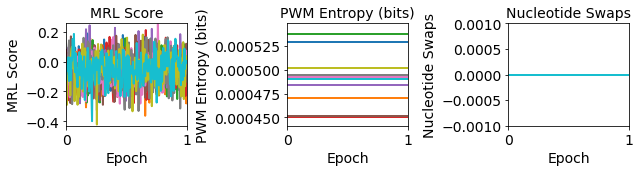

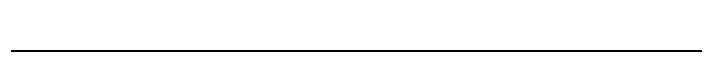

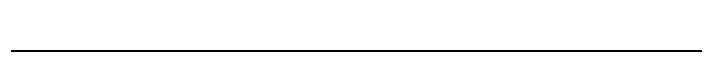

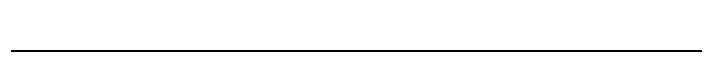

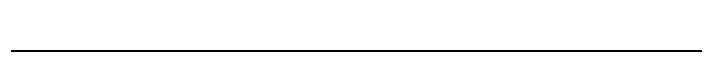

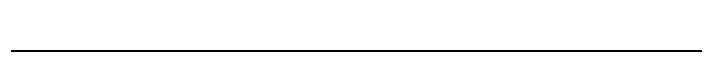

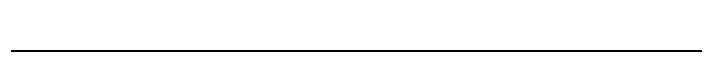

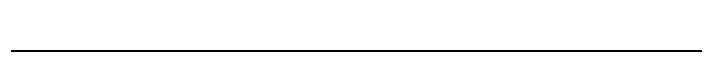

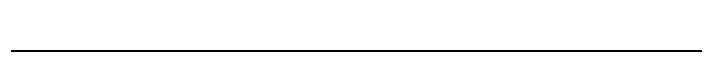

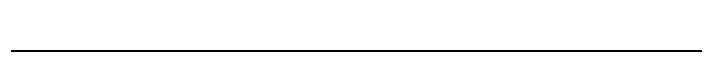

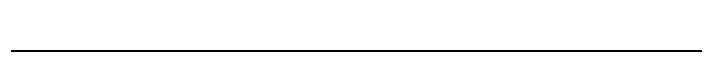

Experiment name = PWM-IN
Eval mode = pwm
Normalize logits = True
Optimizing objective 0...
Epoch 1/1
200/200 [==============================] - 4s 18ms/step - loss: -7.4252


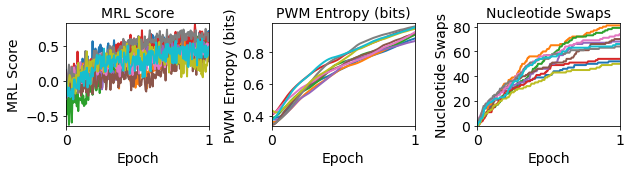

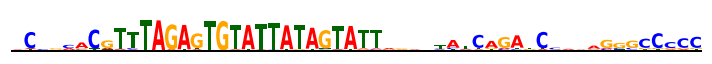

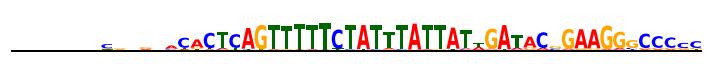

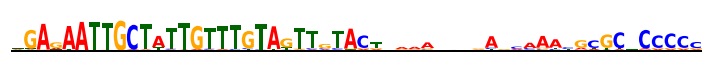

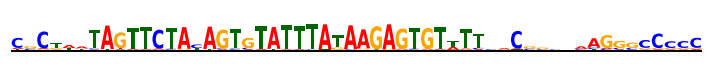

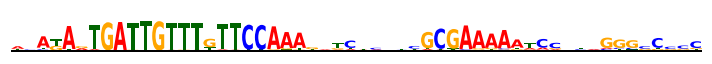

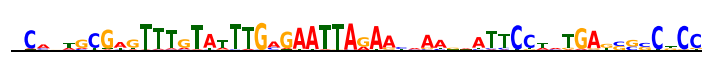

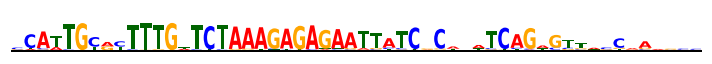

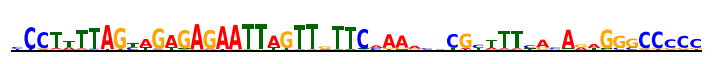

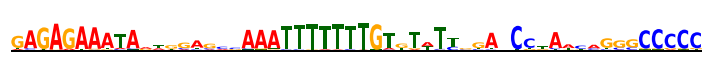

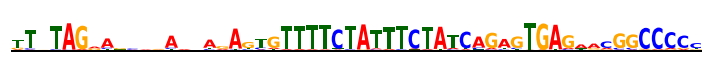

Experiment name = Sampled
Eval mode = sample
Normalize logits = False
Optimizing objective 0...
Epoch 1/1
200/200 [==============================] - 3s 16ms/step - loss: 0.2512


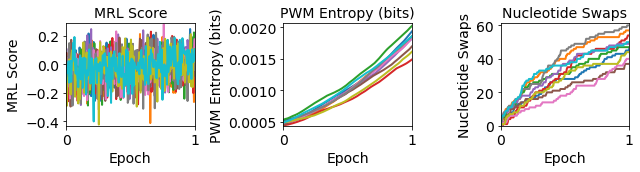

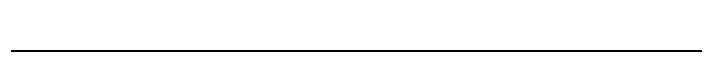

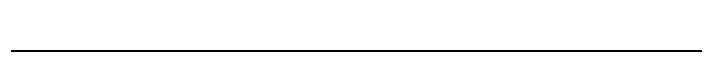

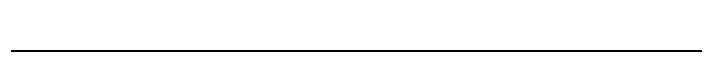

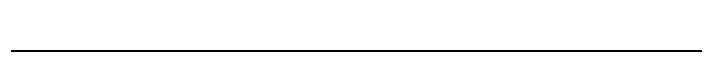

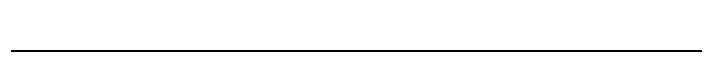

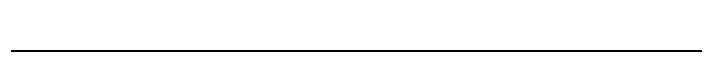

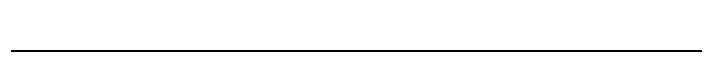

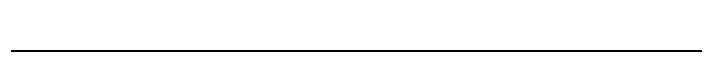

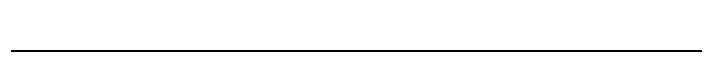

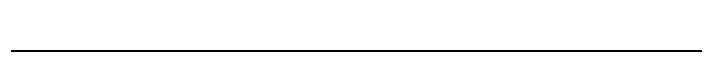

Experiment name = Sampled-IN
Eval mode = sample
Normalize logits = True
Optimizing objective 0...
Epoch 1/1
200/200 [==============================] - 3s 17ms/step - loss: -5.6893


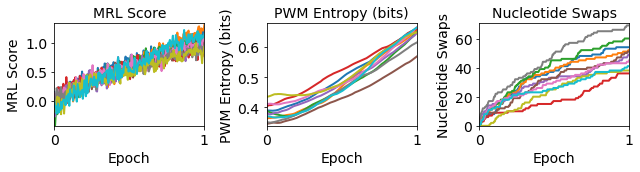

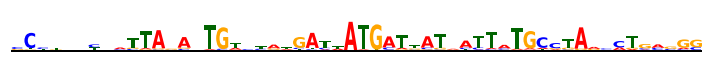

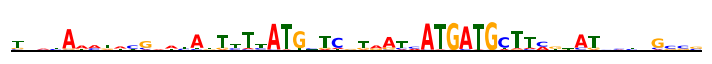

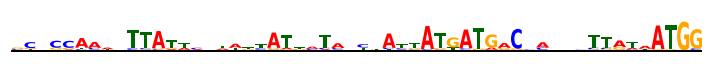

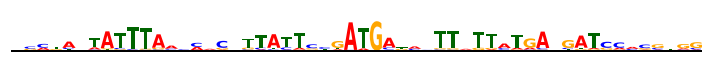

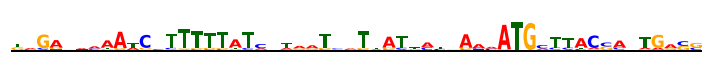

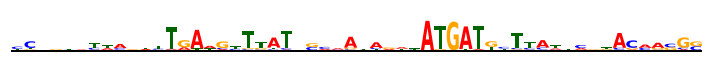

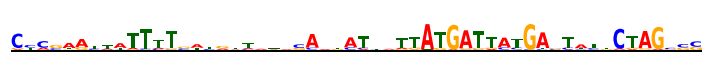

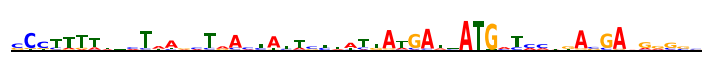

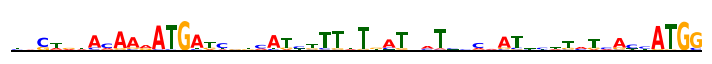

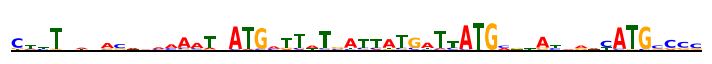

In [15]:

seq_template = 'N' * 54

rand_seed = 1177#14755

#Run SeqProp Optimization

print("Running optimization experiment 'Optimus-5 MRL Maximization'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 200
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 64

experiment_name_list = ['PWM', 'PWM-IN', 'Sampled', 'Sampled-IN']
eval_mode_list = ['pwm', 'pwm', 'sample', 'sample']
normalize_logits_list = [False, True, False, True]

result_dict = {
    'PWM' : {},
    'PWM-In' : {},
    'Sampled' : {},
    'Sampled-In' : {}
}

for experiment_name, eval_mode, normalize_logits in zip(experiment_name_list, eval_mode_list, normalize_logits_list) :
    
    print("Experiment name = " + str(experiment_name))
    print("Eval mode = " + str(eval_mode))
    print("Normalize logits = " + str(normalize_logits))

    K.clear_session()

    set_seed(rand_seed)

    target_output_ixs = [
        125#137
    ]

    sequence_templates = [
        seq_template
    ]

    losses, val_losses = zip(*[
        get_earthmover_loss(
            pwm_start=0,
            pwm_end=54,
            pwm_target_bits=1.8,
            pwm_entropy_weight=0.0
        )
    ])

    transforms = [
        None
    ]

    seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(sequence_templates, losses, val_losses, transforms, n_sequences, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

    seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]

    result_dict[experiment_name] = {
        'seqprop_predictor' : seqprop_predictor,
        'valid_monitor' : valid_monitor,
        'train_history' : train_history,
        'valid_history' : valid_history,
    }


Experiment name = PWM


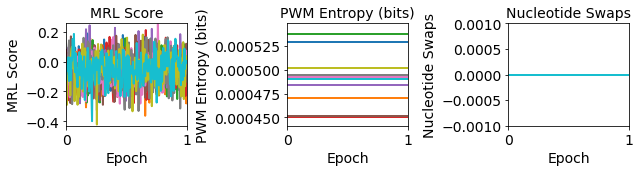

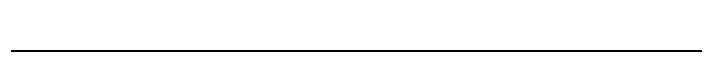

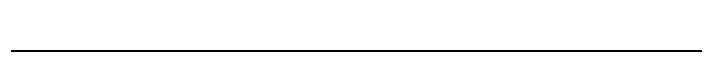

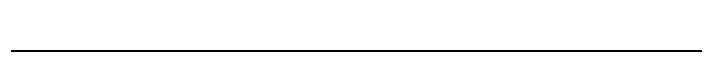

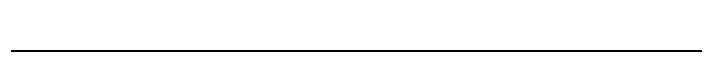

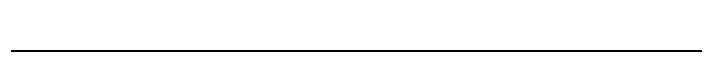

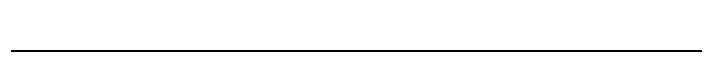

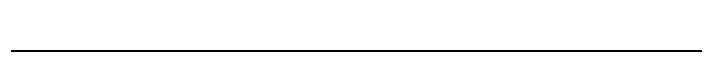

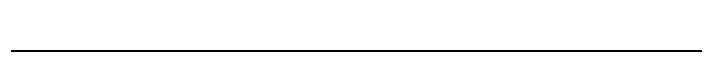

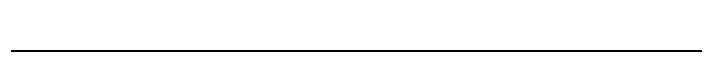

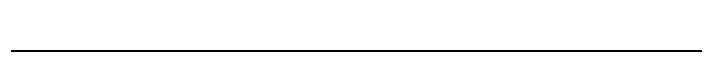

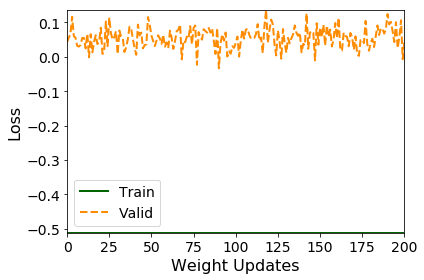

Experiment name = PWM-IN


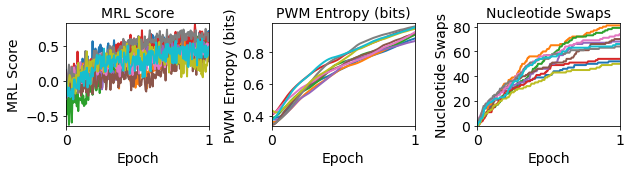

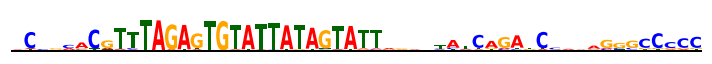

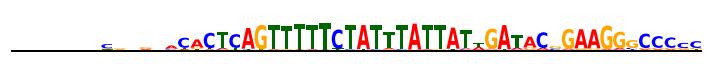

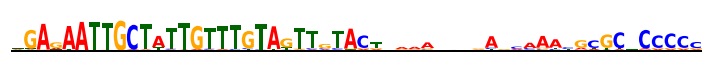

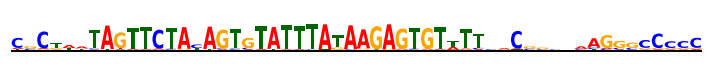

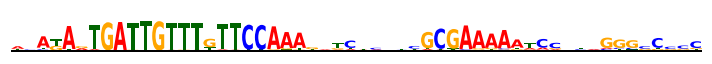

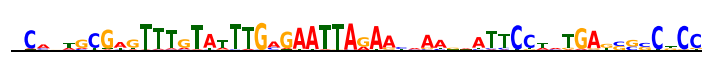

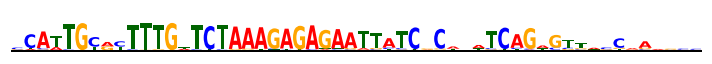

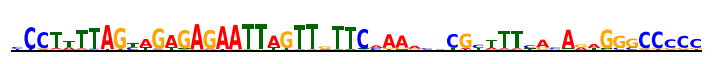

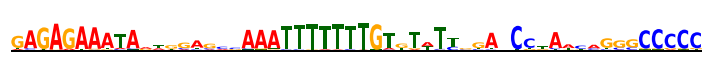

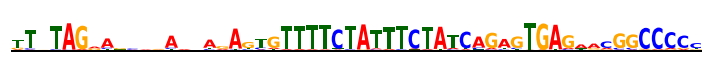

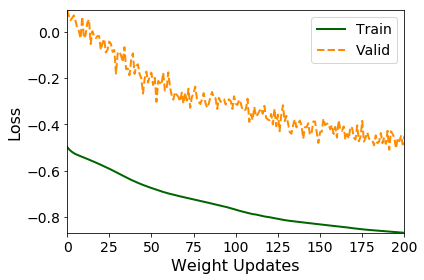

Experiment name = Sampled


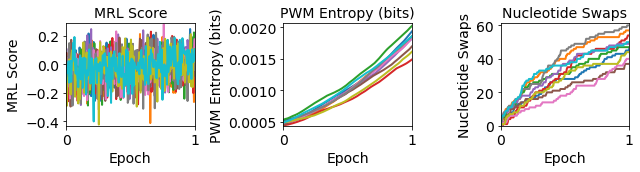

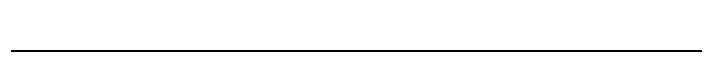

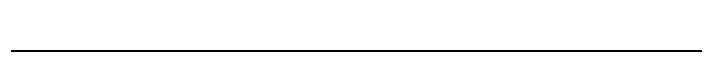

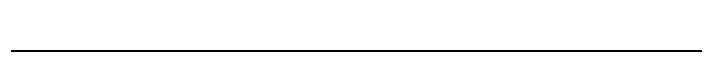

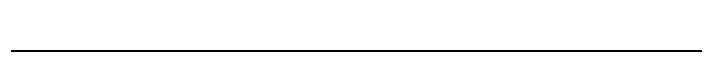

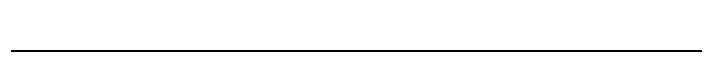

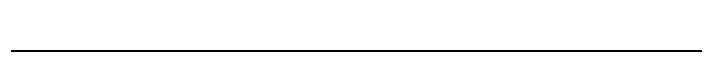

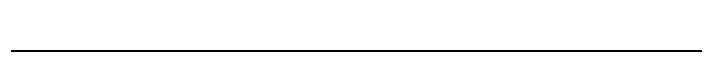

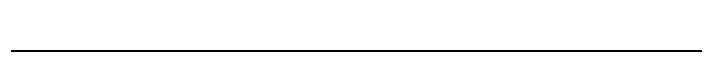

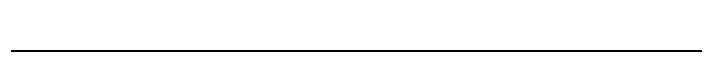

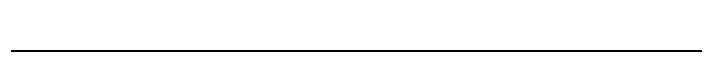

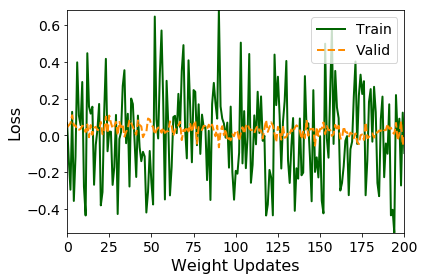

Experiment name = Sampled-IN


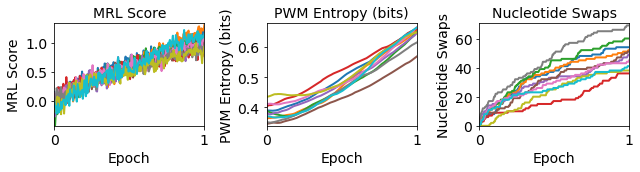

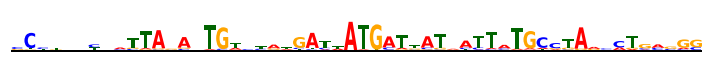

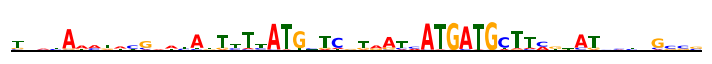

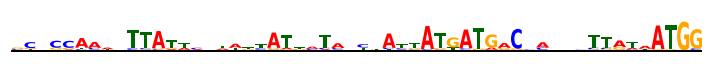

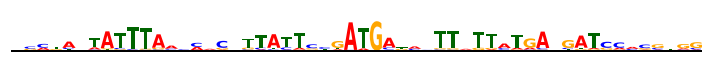

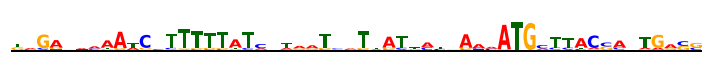

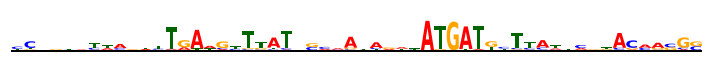

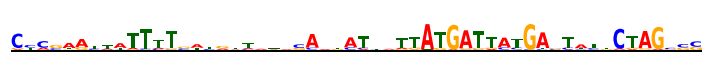

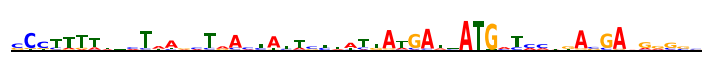

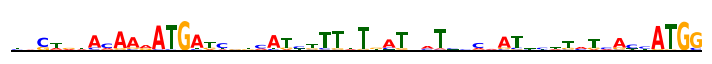

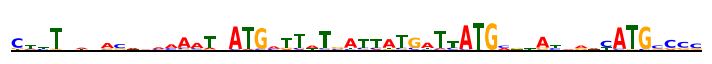

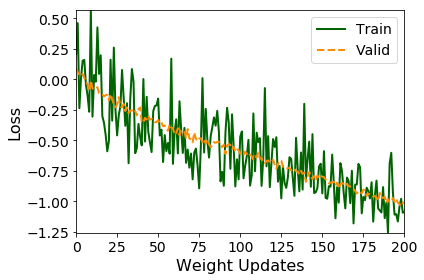

--- Comparison of loss convergence ---


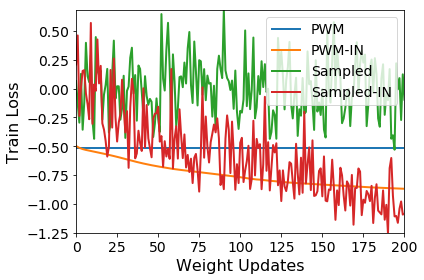

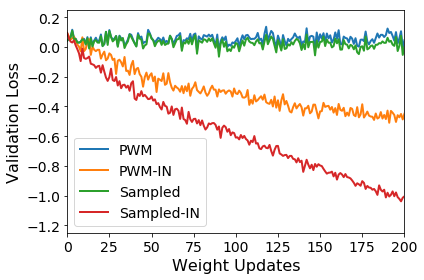

--- Comparison of mrl score convergence ---


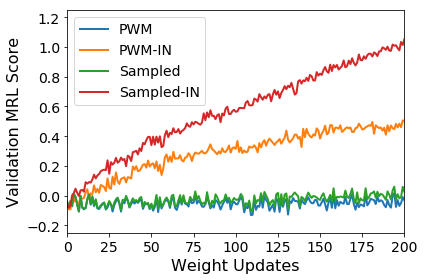

In [16]:

save_figs = True
fig_prefix = "eval_seqprop_optimus5_non_retrained_mrl_earthmover_experiment_200_updates_"

for experiment_ix, experiment_name in enumerate(experiment_name_list) :
    
    print("Experiment name = " + str(experiment_name))

    seqprop_predictor = result_dict[experiment_name]['seqprop_predictor']
    valid_monitor = result_dict[experiment_name]['valid_monitor']
    train_history = result_dict[experiment_name]['train_history']
    valid_history = result_dict[experiment_name]['valid_history']

    #Store statistics for optimized sequences

    fig_name = fig_prefix + experiment_name + "_" if save_figs else None

    valid_monitor.plot_metrics_and_pwm(fig_name=fig_name)

    f = plt.figure(figsize=(6, 4))

    l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(train_history.val_loss_history) / n_sequences, color='darkgreen', linewidth=2, linestyle='-', label='Train')
    l2 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(valid_history.val_loss_history), color='darkorange', linewidth=2, linestyle='--', label='Valid')

    plt.xlabel("Weight Updates", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(0, n_epochs * steps_per_epoch)
    plt.ylim(min(np.min(train_history.val_loss_history) / n_sequences, np.min(valid_history.val_loss_history)), max(np.max(train_history.val_loss_history) / n_sequences, np.max(valid_history.val_loss_history)))

    plt.legend(handles=[l1[0], l2[0]], fontsize=14)
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + '_loss.png', transparent=True, dpi=150)
        plt.savefig(fig_name + '_loss.svg')
        plt.savefig(fig_name + '_loss.eps')

    plt.show()


print("--- Comparison of loss convergence ---")

for history_prefix in ['train', 'valid'] :

    loss_normalizer = n_sequences if history_prefix == 'train' else 1.
    y_label_prefix = 'Train' if history_prefix == 'train' else 'Validation'
    
    f = plt.figure(figsize=(6, 4))

    ls = []
    min_y_val = -1.25
    max_y_val = 0.25

    for experiment_ix, experiment_name in enumerate(experiment_name_list) :
        curr_history = result_dict[experiment_name][history_prefix + '_history']

        l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(curr_history.val_loss_history) / loss_normalizer, linewidth=2, linestyle='-', label=experiment_name)
        ls.append(l1[0])

        max_y_val = max(max_y_val, np.max(curr_history.val_loss_history) / loss_normalizer)

    plt.xlabel("Weight Updates", fontsize=16)
    plt.ylabel(y_label_prefix + " Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(0, n_epochs * steps_per_epoch)
    plt.ylim(min_y_val, max_y_val)

    plt.legend(handles=ls, fontsize=14)
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.png', transparent=True, dpi=150)
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.svg')
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.eps')

    plt.show()

print("--- Comparison of mrl score convergence ---")

f = plt.figure(figsize=(6, 4))

ls = []
min_y_val = -0.25
max_y_val = 1.25

for experiment_ix, experiment_name in enumerate(experiment_name_list) :
    curr_monitor = result_dict[experiment_name]['valid_monitor']
    meas_history = curr_monitor.measure_history
    meas_history = [np.mean(meas_history[k]) for k in range(len(meas_history))]

    l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(meas_history), linewidth=2, linestyle='-', label=experiment_name)
    ls.append(l1[0])

    #max_y_val = max(max_y_val, np.max(meas_history))

plt.xlabel("Weight Updates", fontsize=16)
plt.ylabel("Validation MRL Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, n_epochs * steps_per_epoch)
plt.ylim(min_y_val, max_y_val)

plt.legend(handles=ls, fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig(fig_prefix + '_valid_logodds_cmp.png', transparent=True, dpi=150)
    plt.savefig(fig_prefix + '_valid_logodds_cmp.svg')
    plt.savefig(fig_prefix + '_valid_logodds_cmp.eps')

plt.show()


Running optimization experiment 'Optimus-5 MRL Maximization'
Experiment name = PWM
Eval mode = pwm
Normalize logits = False
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 29s 14ms/step - loss: -5.1177


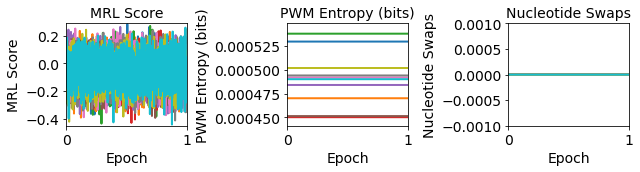

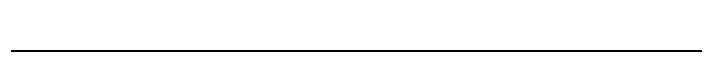

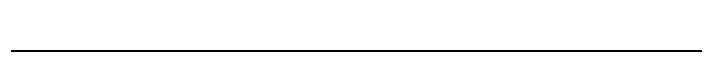

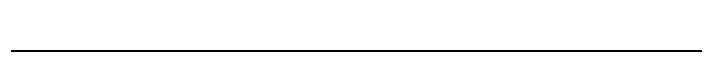

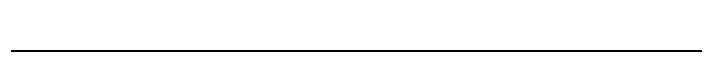

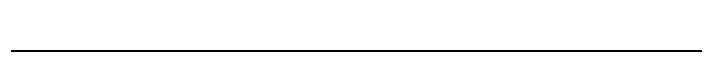

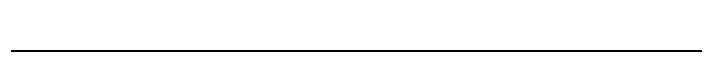

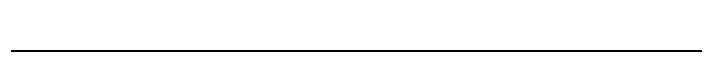

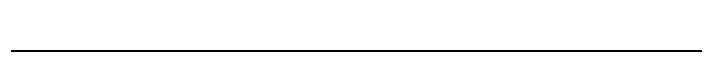

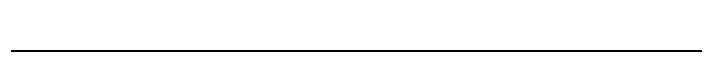

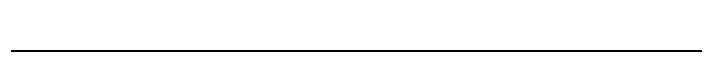

Experiment name = PWM-IN
Eval mode = pwm
Normalize logits = True
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 30s 15ms/step - loss: -12.3946


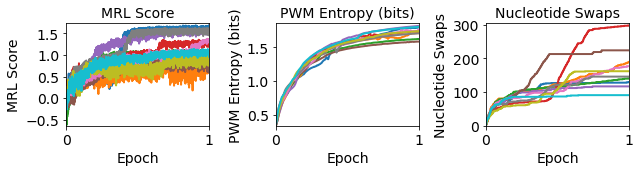

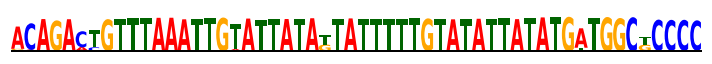

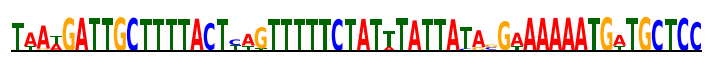

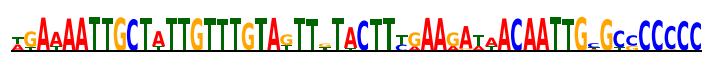

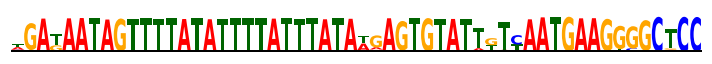

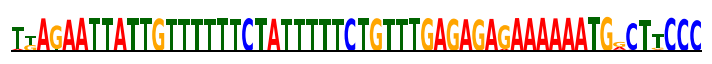

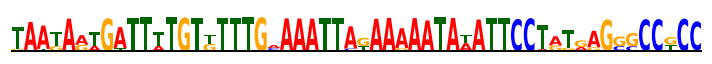

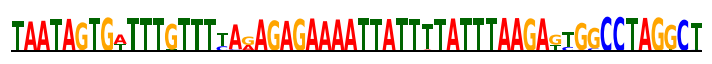

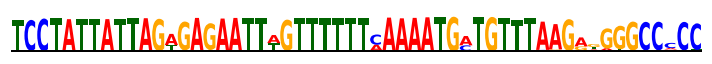

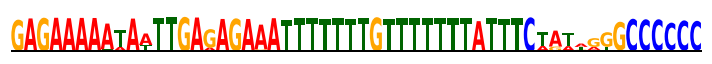

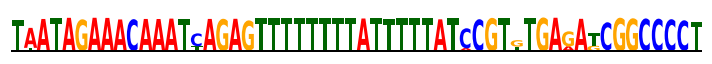

Experiment name = Sampled
Eval mode = sample
Normalize logits = False
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 28s 14ms/step - loss: -1.7497


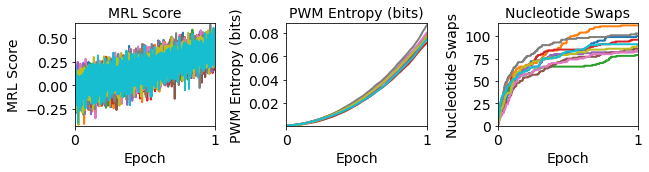

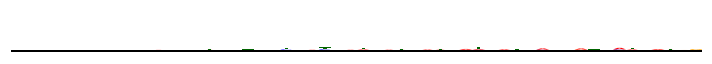

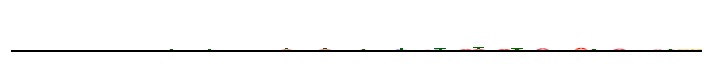

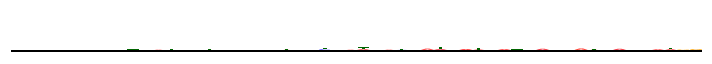

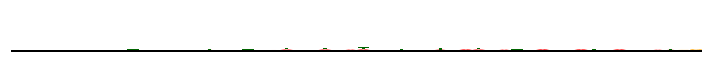

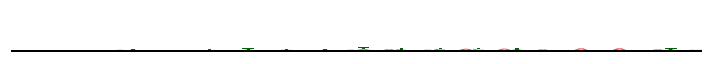

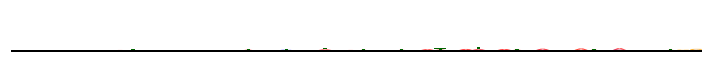

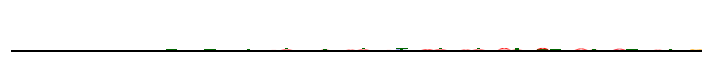

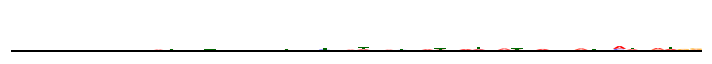

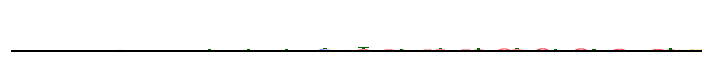

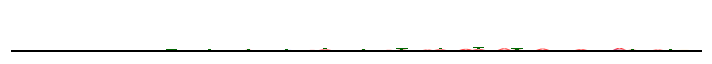

Experiment name = Sampled-IN
Eval mode = sample
Normalize logits = True
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 30s 15ms/step - loss: -20.5864


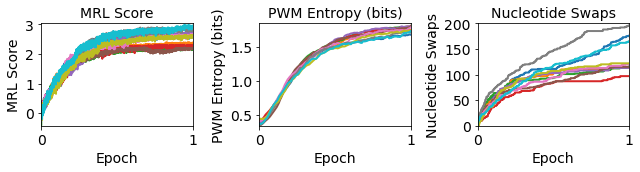

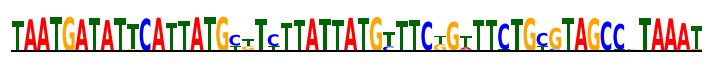

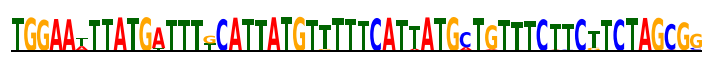

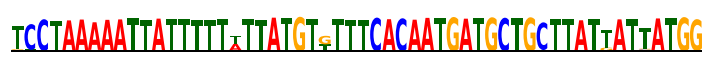

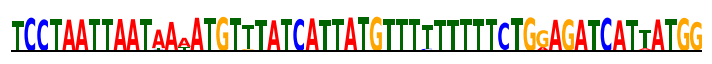

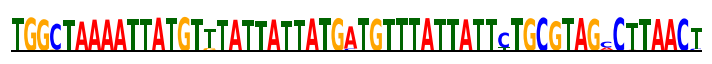

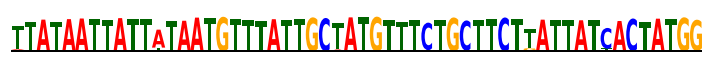

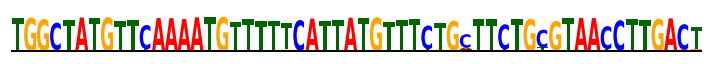

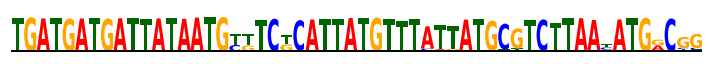

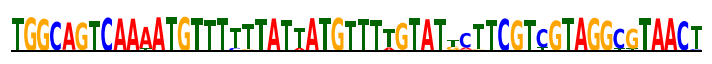

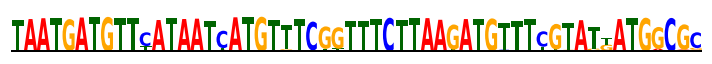

In [17]:

seq_template = 'N' * 54

rand_seed = 1177#14755

#Run SeqProp Optimization

print("Running optimization experiment 'Optimus-5 MRL Maximization'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 64

experiment_name_list = ['PWM', 'PWM-IN', 'Sampled', 'Sampled-IN']
eval_mode_list = ['pwm', 'pwm', 'sample', 'sample']
normalize_logits_list = [False, True, False, True]

result_dict = {
    'PWM' : {},
    'PWM-In' : {},
    'Sampled' : {},
    'Sampled-In' : {}
}

for experiment_name, eval_mode, normalize_logits in zip(experiment_name_list, eval_mode_list, normalize_logits_list) :
    
    print("Experiment name = " + str(experiment_name))
    print("Eval mode = " + str(eval_mode))
    print("Normalize logits = " + str(normalize_logits))

    K.clear_session()

    set_seed(rand_seed)

    target_output_ixs = [
        125#137
    ]

    sequence_templates = [
        seq_template
    ]

    losses, val_losses = zip(*[
        get_earthmover_loss(
            pwm_start=0,
            pwm_end=54,
            pwm_target_bits=1.8,
            pwm_entropy_weight=0.0
        )
    ])

    transforms = [
        None
    ]

    seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(sequence_templates, losses, val_losses, transforms, n_sequences, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

    seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]

    result_dict[experiment_name] = {
        'seqprop_predictor' : seqprop_predictor,
        'valid_monitor' : valid_monitor,
        'train_history' : train_history,
        'valid_history' : valid_history,
    }


Experiment name = PWM


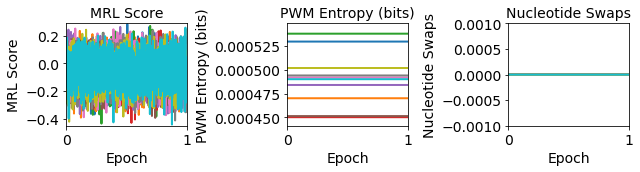

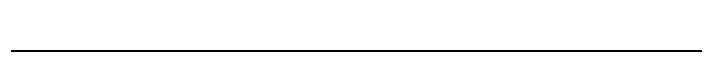

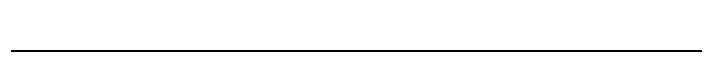

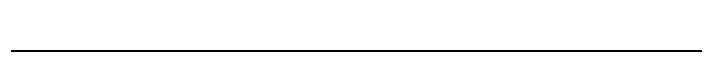

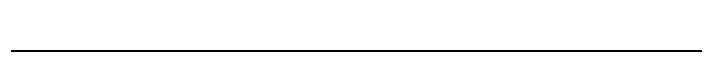

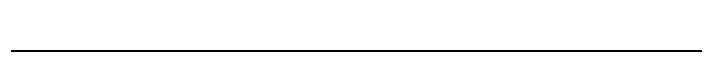

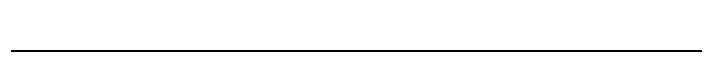

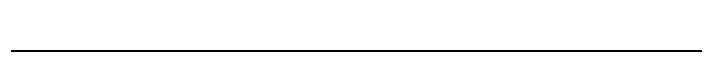

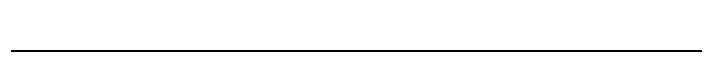

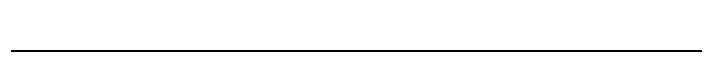

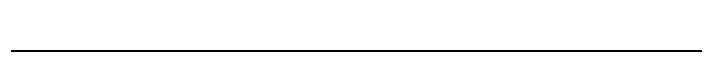

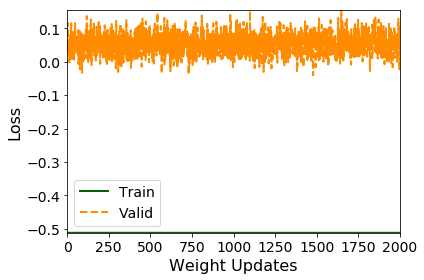

Experiment name = PWM-IN


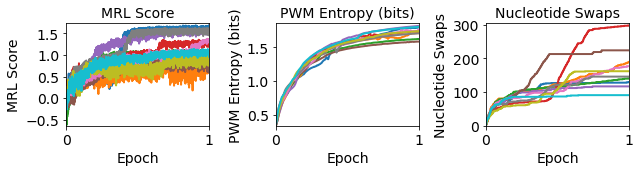

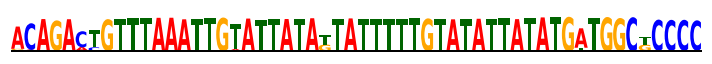

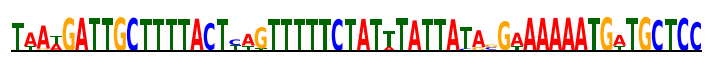

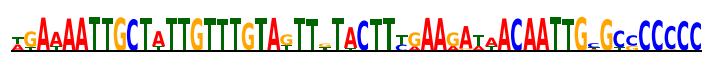

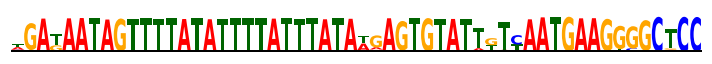

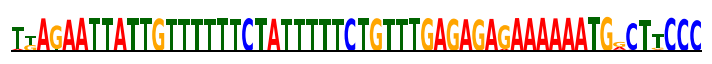

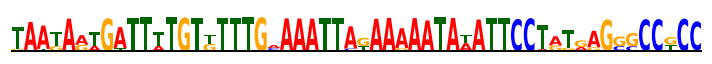

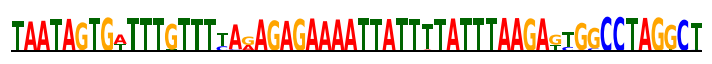

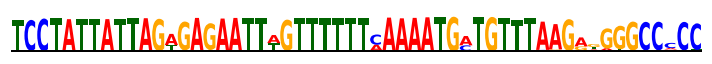

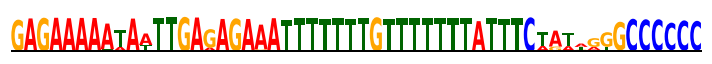

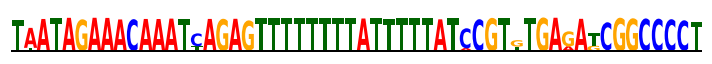

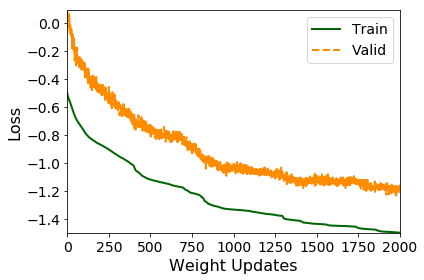

Experiment name = Sampled


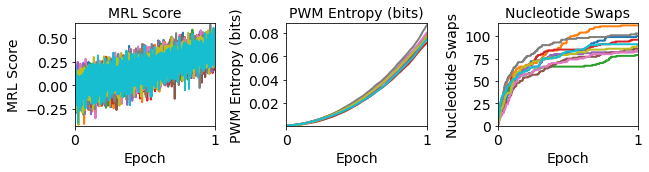

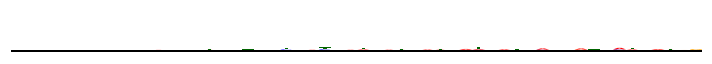

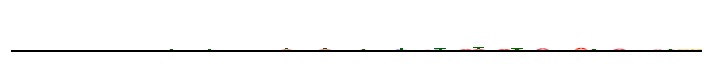

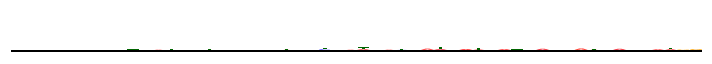

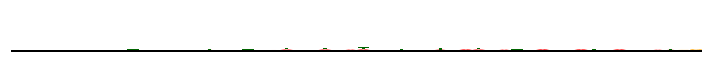

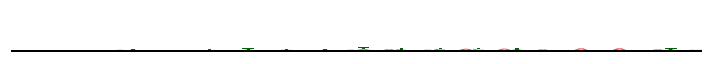

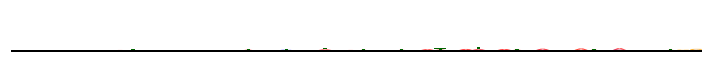

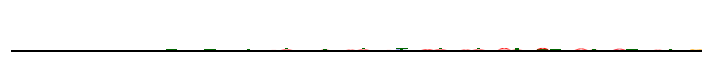

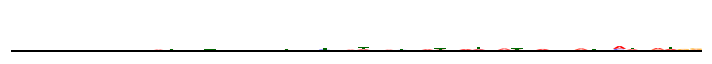

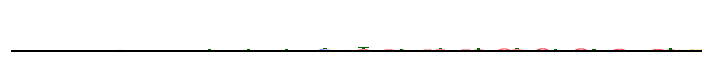

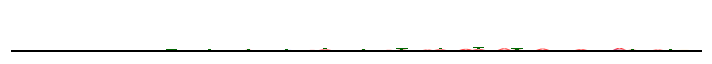

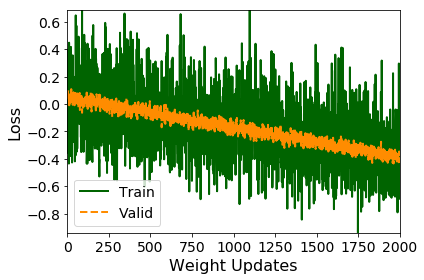

Experiment name = Sampled-IN


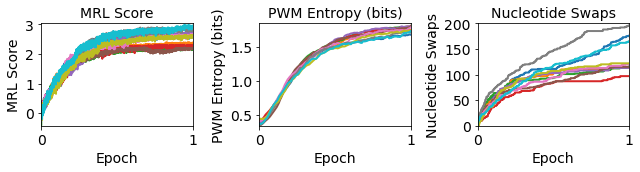

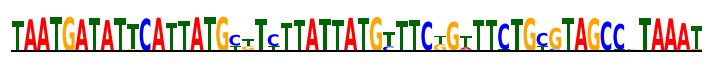

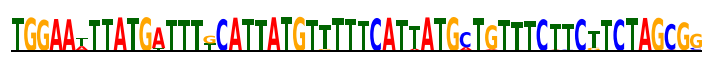

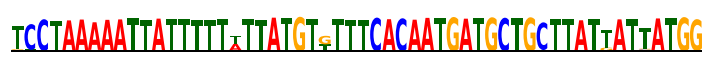

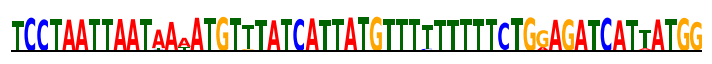

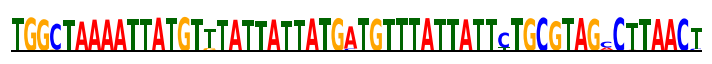

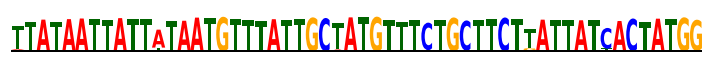

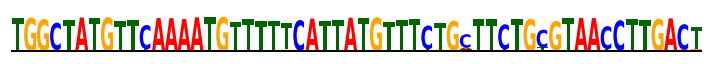

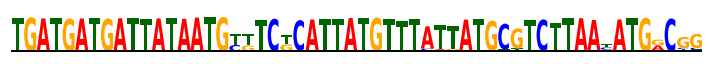

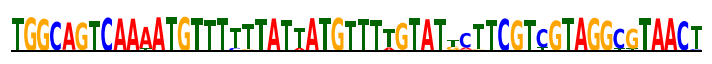

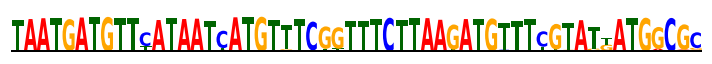

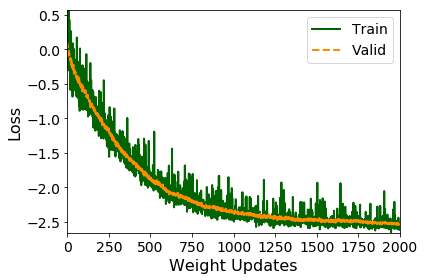

--- Comparison of loss convergence ---


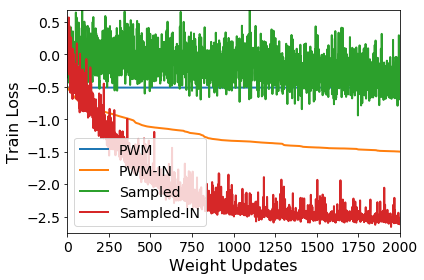

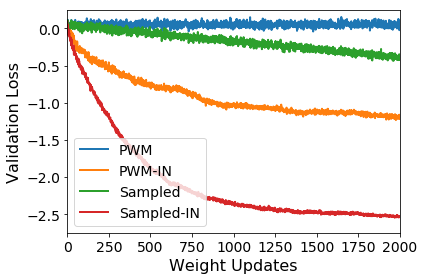

--- Comparison of mrl score convergence ---


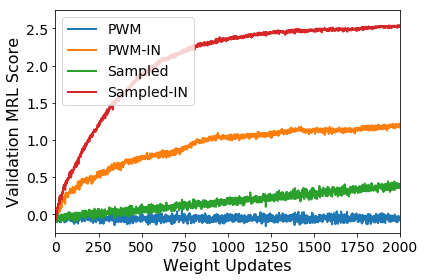

In [19]:

save_figs = True
fig_prefix = "eval_seqprop_optimus5_non_retrained_mrl_earthmover_experiment_2000_updates_"

for experiment_ix, experiment_name in enumerate(experiment_name_list) :
    
    print("Experiment name = " + str(experiment_name))

    seqprop_predictor = result_dict[experiment_name]['seqprop_predictor']
    valid_monitor = result_dict[experiment_name]['valid_monitor']
    train_history = result_dict[experiment_name]['train_history']
    valid_history = result_dict[experiment_name]['valid_history']

    #Store statistics for optimized sequences

    fig_name = fig_prefix + experiment_name + "_" if save_figs else None

    valid_monitor.plot_metrics_and_pwm(fig_name=fig_name)

    f = plt.figure(figsize=(6, 4))

    l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(train_history.val_loss_history) / n_sequences, color='darkgreen', linewidth=2, linestyle='-', label='Train')
    l2 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(valid_history.val_loss_history), color='darkorange', linewidth=2, linestyle='--', label='Valid')

    plt.xlabel("Weight Updates", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(0, n_epochs * steps_per_epoch)
    plt.ylim(min(np.min(train_history.val_loss_history) / n_sequences, np.min(valid_history.val_loss_history)), max(np.max(train_history.val_loss_history) / n_sequences, np.max(valid_history.val_loss_history)))

    plt.legend(handles=[l1[0], l2[0]], fontsize=14)
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + '_loss.png', transparent=True, dpi=150)
        plt.savefig(fig_name + '_loss.svg')
        plt.savefig(fig_name + '_loss.eps')

    plt.show()


print("--- Comparison of loss convergence ---")

for history_prefix in ['train', 'valid'] :

    loss_normalizer = n_sequences if history_prefix == 'train' else 1.
    y_label_prefix = 'Train' if history_prefix == 'train' else 'Validation'
    
    f = plt.figure(figsize=(6, 4))

    ls = []
    min_y_val = -2.75
    max_y_val = 0.25

    for experiment_ix, experiment_name in enumerate(experiment_name_list) :
        curr_history = result_dict[experiment_name][history_prefix + '_history']

        l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(curr_history.val_loss_history) / loss_normalizer, linewidth=2, linestyle='-', label=experiment_name)
        ls.append(l1[0])

        max_y_val = max(max_y_val, np.max(curr_history.val_loss_history) / loss_normalizer)

    plt.xlabel("Weight Updates", fontsize=16)
    plt.ylabel(y_label_prefix + " Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(0, n_epochs * steps_per_epoch)
    plt.ylim(min_y_val, max_y_val)

    plt.legend(handles=ls, fontsize=14)
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.png', transparent=True, dpi=150)
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.svg')
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.eps')

    plt.show()

print("--- Comparison of mrl score convergence ---")

f = plt.figure(figsize=(6, 4))

ls = []
min_y_val = -0.25
max_y_val = 2.75

for experiment_ix, experiment_name in enumerate(experiment_name_list) :
    curr_monitor = result_dict[experiment_name]['valid_monitor']
    meas_history = curr_monitor.measure_history
    meas_history = [np.mean(meas_history[k]) for k in range(len(meas_history))]

    l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(meas_history), linewidth=2, linestyle='-', label=experiment_name)
    ls.append(l1[0])

    #max_y_val = max(max_y_val, np.max(meas_history))

plt.xlabel("Weight Updates", fontsize=16)
plt.ylabel("Validation MRL Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, n_epochs * steps_per_epoch)
plt.ylim(min_y_val, max_y_val)

plt.legend(handles=ls, fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig(fig_prefix + '_valid_logodds_cmp.png', transparent=True, dpi=150)
    plt.savefig(fig_prefix + '_valid_logodds_cmp.svg')
    plt.savefig(fig_prefix + '_valid_logodds_cmp.eps')

plt.show()


Running optimization experiment 'Optimus-5 MRL Maximization'
Experiment name = PWM
Eval mode = pwm
Normalize logits = False
Optimizing objective 0...
Epoch 1/1
20000/20000 [==============================] - 271s 14ms/step - loss: -5.1177


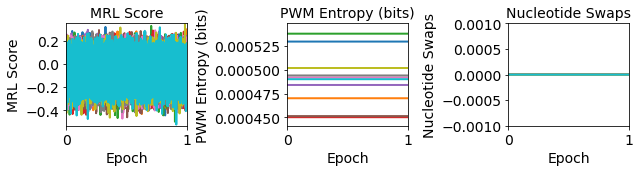

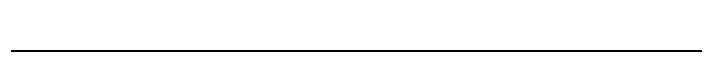

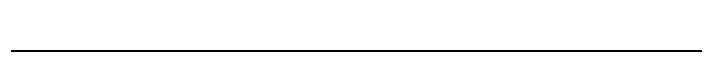

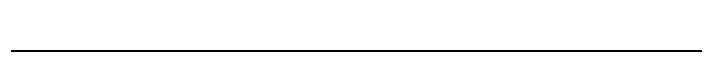

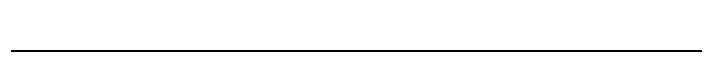

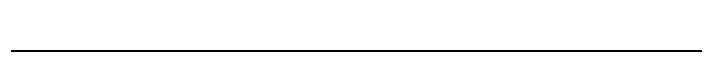

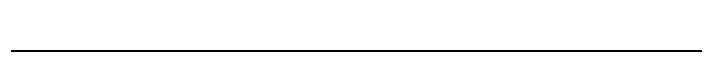

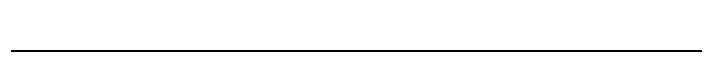

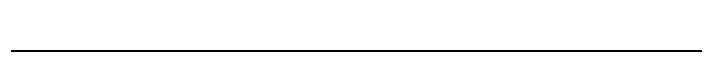

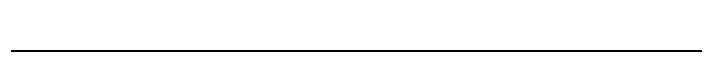

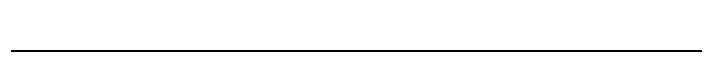

Experiment name = PWM-IN
Eval mode = pwm
Normalize logits = True
Optimizing objective 0...
Epoch 1/1
20000/20000 [==============================] - 298s 15ms/step - loss: -16.2280


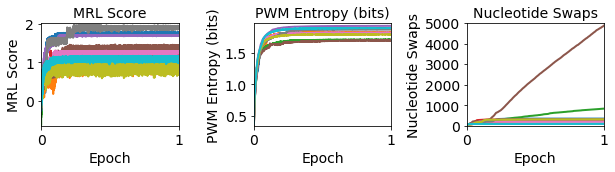

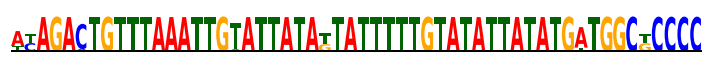

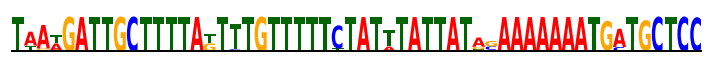

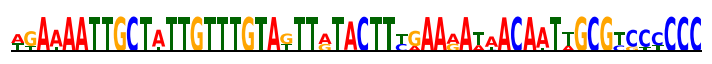

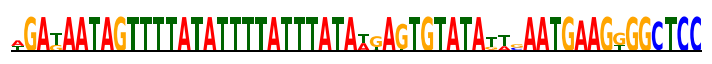

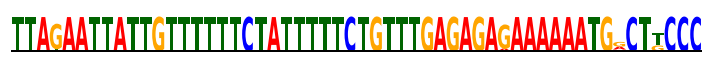

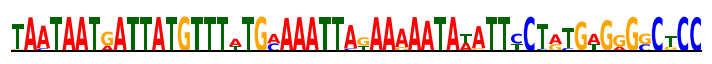

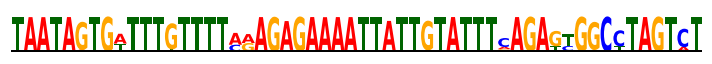

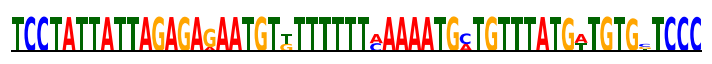

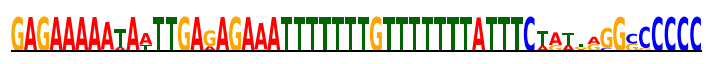

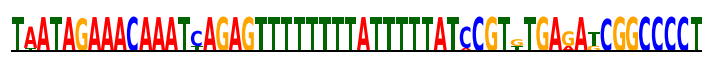

Experiment name = Sampled
Eval mode = sample
Normalize logits = False
Optimizing objective 0...
Epoch 1/1
20000/20000 [==============================] - 277s 14ms/step - loss: -15.9960


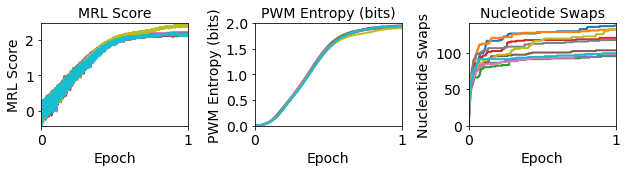

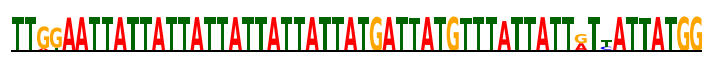

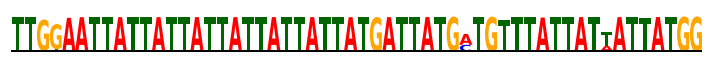

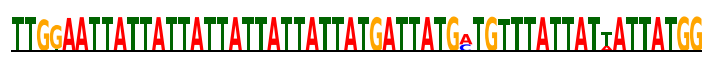

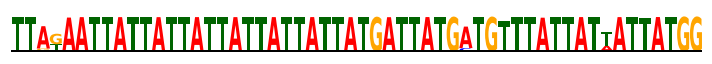

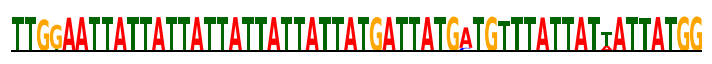

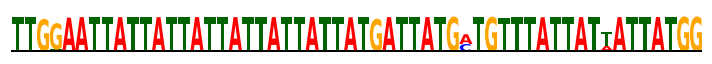

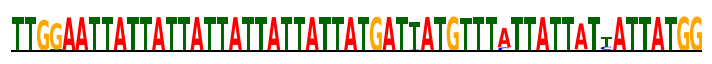

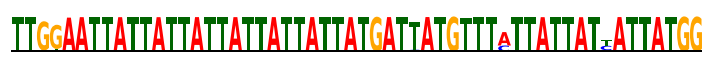

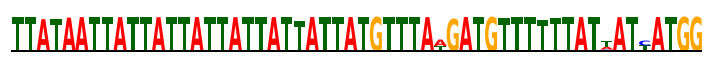

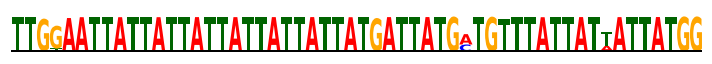

Experiment name = Sampled-IN
Eval mode = sample
Normalize logits = True
Optimizing objective 0...
Epoch 1/1
20000/20000 [==============================] - 297s 15ms/step - loss: -25.8425


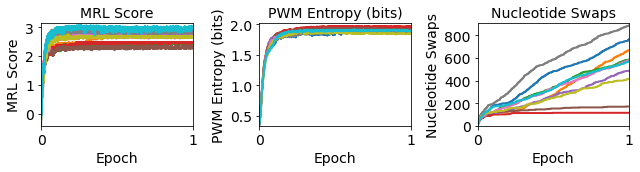

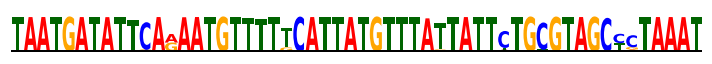

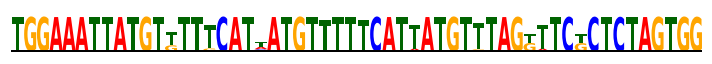

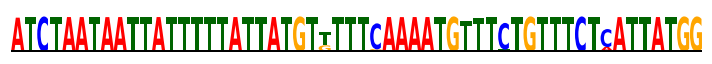

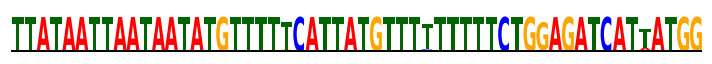

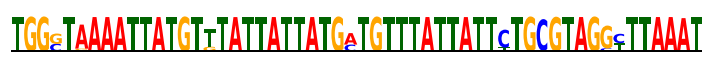

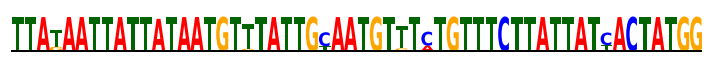

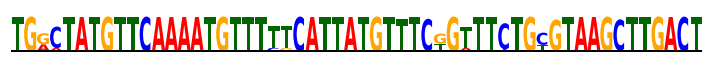

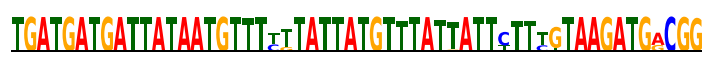

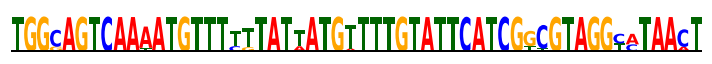

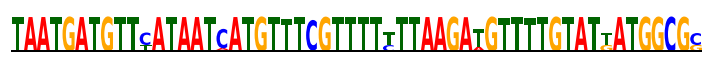

In [20]:

seq_template = 'N' * 54

rand_seed = 1177#14755

#Run SeqProp Optimization

print("Running optimization experiment 'Optimus-5 MRL Maximization'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 20000
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 64

experiment_name_list = ['PWM', 'PWM-IN', 'Sampled', 'Sampled-IN']
eval_mode_list = ['pwm', 'pwm', 'sample', 'sample']
normalize_logits_list = [False, True, False, True]

result_dict = {
    'PWM' : {},
    'PWM-In' : {},
    'Sampled' : {},
    'Sampled-In' : {}
}

for experiment_name, eval_mode, normalize_logits in zip(experiment_name_list, eval_mode_list, normalize_logits_list) :
    
    print("Experiment name = " + str(experiment_name))
    print("Eval mode = " + str(eval_mode))
    print("Normalize logits = " + str(normalize_logits))

    K.clear_session()

    set_seed(rand_seed)

    target_output_ixs = [
        125#137
    ]

    sequence_templates = [
        seq_template
    ]

    losses, val_losses = zip(*[
        get_earthmover_loss(
            pwm_start=0,
            pwm_end=54,
            pwm_target_bits=1.8,
            pwm_entropy_weight=0.0
        )
    ])

    transforms = [
        None
    ]

    seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(sequence_templates, losses, val_losses, transforms, n_sequences, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

    seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]

    result_dict[experiment_name] = {
        'seqprop_predictor' : seqprop_predictor,
        'valid_monitor' : valid_monitor,
        'train_history' : train_history,
        'valid_history' : valid_history,
    }


Experiment name = PWM


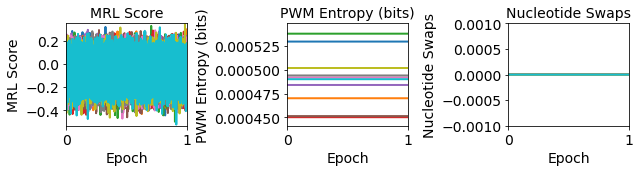

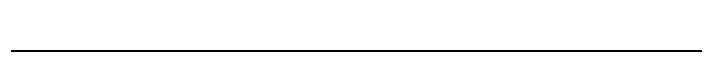

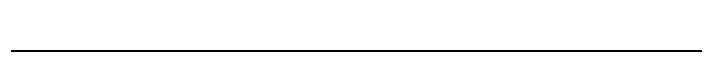

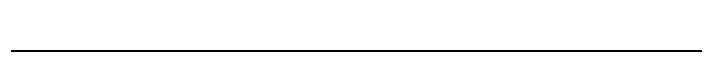

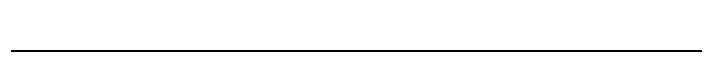

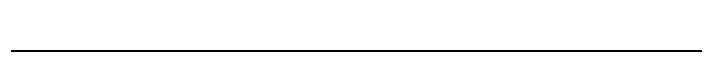

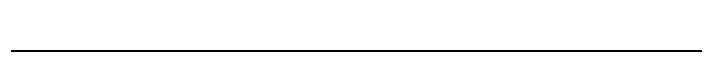

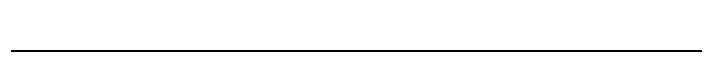

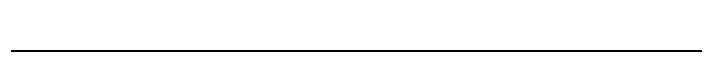

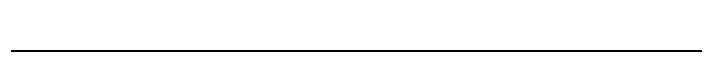

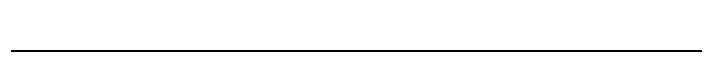

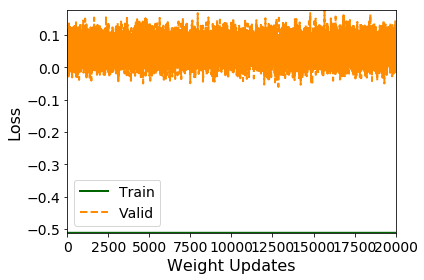

Experiment name = PWM-IN


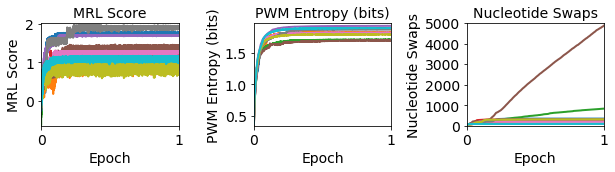

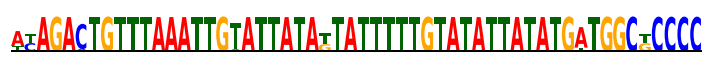

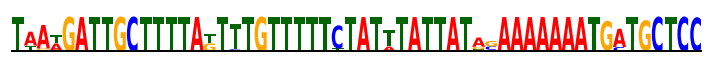

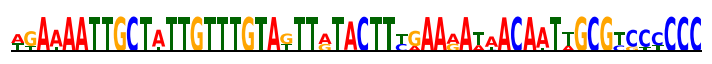

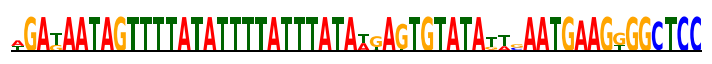

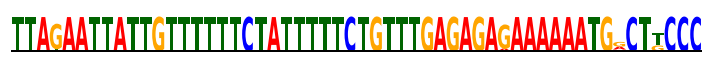

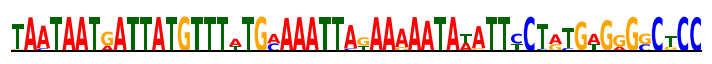

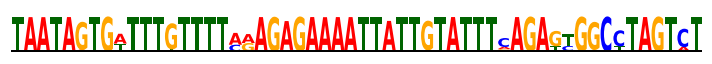

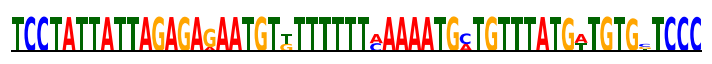

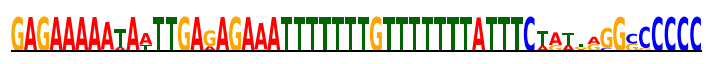

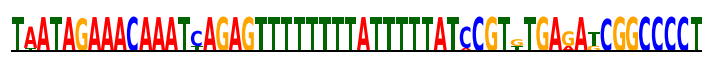

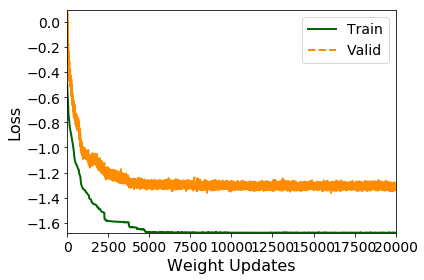

Experiment name = Sampled


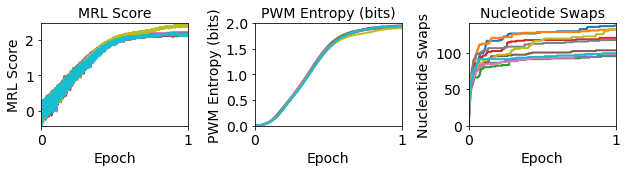

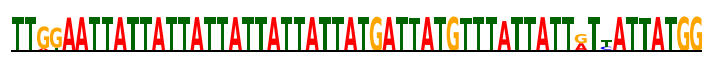

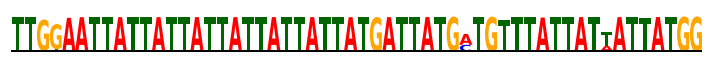

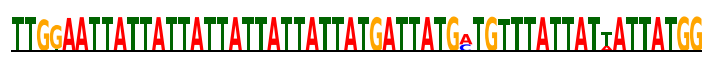

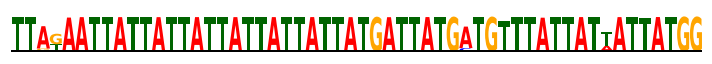

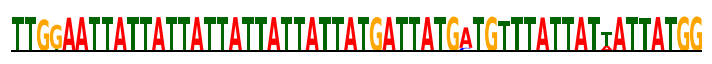

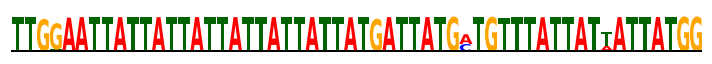

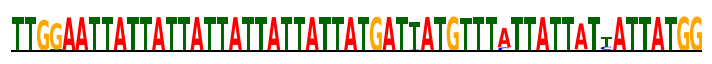

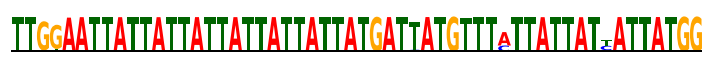

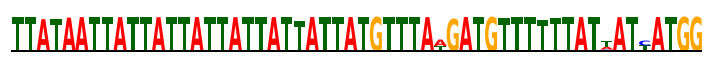

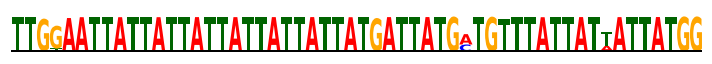

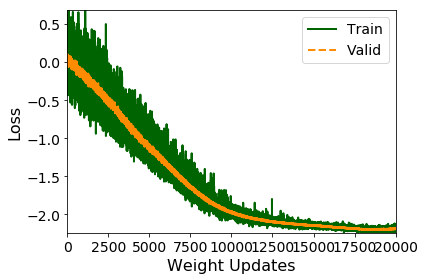

Experiment name = Sampled-IN


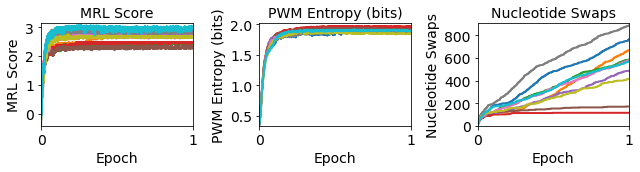

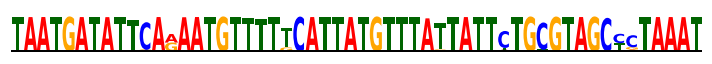

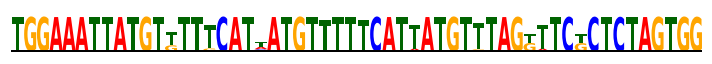

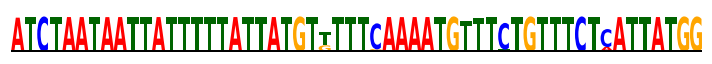

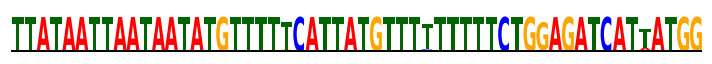

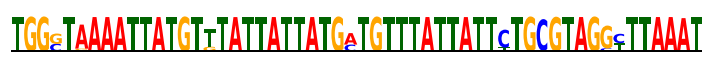

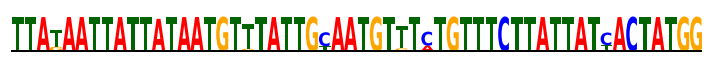

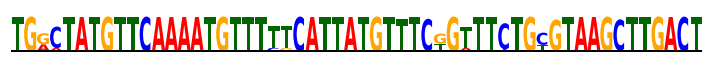

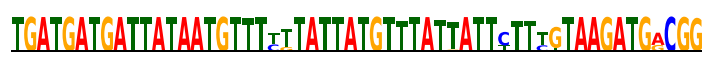

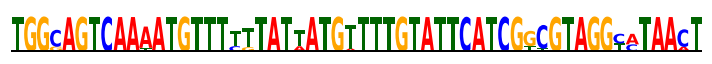

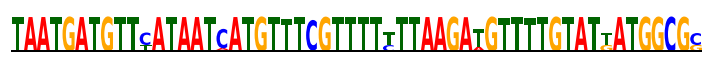

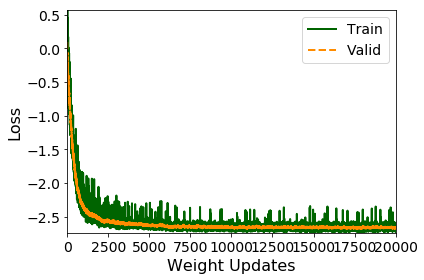

--- Comparison of loss convergence ---


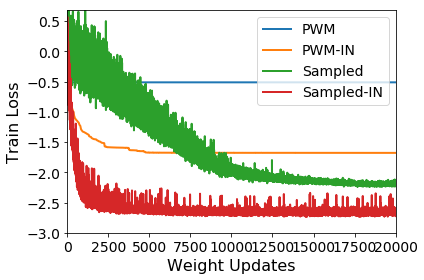

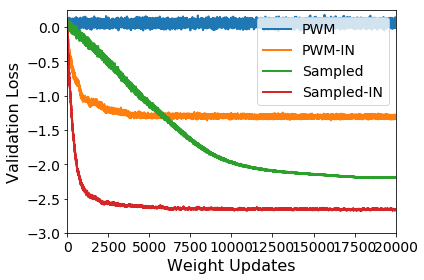

--- Comparison of mrl score convergence ---


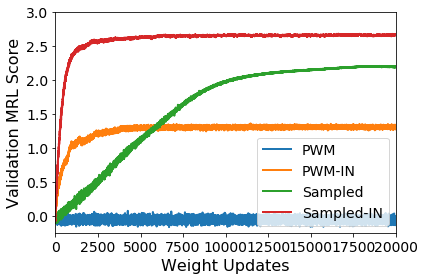

In [21]:

save_figs = True
fig_prefix = "eval_seqprop_optimus5_non_retrained_mrl_earthmover_experiment_20000_updates_"

for experiment_ix, experiment_name in enumerate(experiment_name_list) :
    
    print("Experiment name = " + str(experiment_name))

    seqprop_predictor = result_dict[experiment_name]['seqprop_predictor']
    valid_monitor = result_dict[experiment_name]['valid_monitor']
    train_history = result_dict[experiment_name]['train_history']
    valid_history = result_dict[experiment_name]['valid_history']

    #Store statistics for optimized sequences

    fig_name = fig_prefix + experiment_name + "_" if save_figs else None

    valid_monitor.plot_metrics_and_pwm(fig_name=fig_name)

    f = plt.figure(figsize=(6, 4))

    l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(train_history.val_loss_history) / n_sequences, color='darkgreen', linewidth=2, linestyle='-', label='Train')
    l2 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(valid_history.val_loss_history), color='darkorange', linewidth=2, linestyle='--', label='Valid')

    plt.xlabel("Weight Updates", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(0, n_epochs * steps_per_epoch)
    plt.ylim(min(np.min(train_history.val_loss_history) / n_sequences, np.min(valid_history.val_loss_history)), max(np.max(train_history.val_loss_history) / n_sequences, np.max(valid_history.val_loss_history)))

    plt.legend(handles=[l1[0], l2[0]], fontsize=14)
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + '_loss.png', transparent=True, dpi=150)
        plt.savefig(fig_name + '_loss.svg')
        plt.savefig(fig_name + '_loss.eps')

    plt.show()


print("--- Comparison of loss convergence ---")

for history_prefix in ['train', 'valid'] :

    loss_normalizer = n_sequences if history_prefix == 'train' else 1.
    y_label_prefix = 'Train' if history_prefix == 'train' else 'Validation'
    
    f = plt.figure(figsize=(6, 4))

    ls = []
    min_y_val = -3.0
    max_y_val = 0.25

    for experiment_ix, experiment_name in enumerate(experiment_name_list) :
        curr_history = result_dict[experiment_name][history_prefix + '_history']

        l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(curr_history.val_loss_history) / loss_normalizer, linewidth=2, linestyle='-', label=experiment_name)
        ls.append(l1[0])

        max_y_val = max(max_y_val, np.max(curr_history.val_loss_history) / loss_normalizer)

    plt.xlabel("Weight Updates", fontsize=16)
    plt.ylabel(y_label_prefix + " Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(0, n_epochs * steps_per_epoch)
    plt.ylim(min_y_val, max_y_val)

    plt.legend(handles=ls, fontsize=14)
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.png', transparent=True, dpi=150)
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.svg')
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.eps')

    plt.show()

print("--- Comparison of mrl score convergence ---")

f = plt.figure(figsize=(6, 4))

ls = []
min_y_val = -0.25
max_y_val = 3.0

for experiment_ix, experiment_name in enumerate(experiment_name_list) :
    curr_monitor = result_dict[experiment_name]['valid_monitor']
    meas_history = curr_monitor.measure_history
    meas_history = [np.mean(meas_history[k]) for k in range(len(meas_history))]

    l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(meas_history), linewidth=2, linestyle='-', label=experiment_name)
    ls.append(l1[0])

    #max_y_val = max(max_y_val, np.max(meas_history))

plt.xlabel("Weight Updates", fontsize=16)
plt.ylabel("Validation MRL Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, n_epochs * steps_per_epoch)
plt.ylim(min_y_val, max_y_val)

plt.legend(handles=ls, fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig(fig_prefix + '_valid_logodds_cmp.png', transparent=True, dpi=150)
    plt.savefig(fig_prefix + '_valid_logodds_cmp.svg')
    plt.savefig(fig_prefix + '_valid_logodds_cmp.eps')

plt.show()
